### Imports

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

# Simulation classes and functions

### Matrices

#### Create matrix A

In [59]:
class MatrixA:
    def __init__(self, m, D, H, Tt, Tg, R, Tj) -> None:
        self.define_sumbatrices_A(m)
        self.assign_submatrices_A(m, D, H, Tt, Tg, R, Tj)
        self.combine_submatrices_A_into_A(m)
        
    
    def define_sumbatrices_A(self, m) -> None:        
        self.A11 = np.zeros([2, 2])
        self.A12 = np.zeros([2, m])
        self.A13 = np.zeros([2, m])
        self.A21 = np.zeros([m, 2])
        self.A22 = np.zeros([m, m])
        self.A23 = np.zeros([m, m])
        self.A31 = np.zeros([m, 2])
        self.A32 = np.zeros([m, m])
        self.A33 = np.zeros([m, m])
        self.A = np.zeros([2+2*m, 2+2*m])
        
        
    def assign_submatrices_A(self, m, D, H, Tt, Tg, R, Tj) -> None:
        sumTj = np.sum(Tj) # -Tj - don't need to do this because Tii is always 0
        Hi_inv = 1/(2*H)

        for j in range(m):
            self.A22[j, j] = -1/Tt[j]            # m x m diag
            self.A31[j] = [-1/(Tg[j] * R[j]), 0] # m x 2
            self.A33[j, j] = -1/Tg[j]            # m x m diag

        self.A11[:, :] = [[    -D*Hi_inv, -Hi_inv], # 2 x 2
                         [2*np.pi*sumTj,       0]]
        self.A12[:, :] = [[Hi_inv]*m,               # 2 x m
                          [     0]*m]
        self.A13[:, :] = [[0]*m,                    # 2 x m
                          [0]*m]
        self.A21 = np.transpose(self.A13)     # m x 2
        self.A23 = -self.A22.copy()
        self.A32 = np.full([m, m], 0)         # m x m


    def combine_submatrices_A_into_A(self, m):
        rowsA = [0, 0, 0,   2, 2, 2,   2+m, 2+m, 2+m]
        colsA = [0, 2, 2+m, 0, 2, 2+m, 0,   2,   2+m]

        #A[i] = [[A11[i], A12[i], A13[i]],
        #        [A21[i], A22[i], A23[i]],
        #        [A31[i], A32[i], A33[i]]]
        self.A[rowsA[0]:rowsA[0]+self.A11.shape[0], colsA[0]:colsA[0]+self.A11.shape[1]] = self.A11
        self.A[rowsA[1]:rowsA[1]+self.A12.shape[0], colsA[1]:colsA[1]+self.A12.shape[1]] = self.A12
        self.A[rowsA[2]:rowsA[2]+self.A13.shape[0], colsA[2]:colsA[2]+self.A13.shape[1]] = self.A13
        self.A[rowsA[3]:rowsA[3]+self.A21.shape[0], colsA[3]:colsA[3]+self.A21.shape[1]] = self.A21
        self.A[rowsA[4]:rowsA[4]+self.A22.shape[0], colsA[4]:colsA[4]+self.A22.shape[1]] = self.A22
        self.A[rowsA[5]:rowsA[5]+self.A23.shape[0], colsA[5]:colsA[5]+self.A23.shape[1]] = self.A23
        self.A[rowsA[6]:rowsA[6]+self.A31.shape[0], colsA[6]:colsA[6]+self.A31.shape[1]] = self.A31
        self.A[rowsA[7]:rowsA[7]+self.A32.shape[0], colsA[7]:colsA[7]+self.A32.shape[1]] = self.A32
        self.A[rowsA[8]:rowsA[8]+self.A33.shape[0], colsA[8]:colsA[8]+self.A33.shape[1]] = self.A33
        
    
    def get_A(self) -> np.ndarray:
        return self.A

#### Create Matrix B1

In [60]:
class MatrixB1:
    def __init__(self, m, H) -> None:
        self.define_sumbatrices_B1(m)
        self.assign_submatrices_B1(m, H)
        self.combine_submatrices_B1_into_B1(m)
        
    
    def define_sumbatrices_B1(self, m) -> None: 
        self.B11 = np.zeros([2, 2])
        self.B12 = np.zeros([m, 2])
        self.B13 = np.zeros([m, 2])
        self.B1 = np.zeros([2+2*m, 2])
        
    def assign_submatrices_B1(self, m, H) -> None:
        Hi_inv = 1/(2*H)
            
        self.B11[:, :] = [[-Hi_inv,        0], # 2 x 2
                          [      0, -2*np.pi]]
        self.B12[:, :] = [[0, 0]]*m            # m x 2
        self.B13 = self.B12.copy()             # m x 2
        
        
    def combine_submatrices_B1_into_B1(self, m) -> None:
        rowsB1 = [0, 2, 2+m]; colsB1 = 0
        
        #B1[i] = [B11[i],
        #         B12[i],
        #         B13[i]]
        self.B1[rowsB1[0]:rowsB1[0]+self.B11.shape[0], colsB1:colsB1+self.B11.shape[1]] = self.B11
        self.B1[rowsB1[1]:rowsB1[1]+self.B12.shape[0], colsB1:colsB1+self.B12.shape[1]] = self.B12
        self.B1[rowsB1[2]:rowsB1[2]+self.B13.shape[0], colsB1:colsB1+self.B13.shape[1]] = self.B13
        
    
    def get_B1(self) -> np.ndarray:
        return self.B1

#### Create Matrix B2

In [61]:
class MatrixB2:
    def __init__(self, m, Tg, alpha) -> None:
        self.define_sumbatrices_B2(m)
        self.assign_submatrices_B2(m, Tg, alpha)
        self.combine_submatrices_B2_into_B2(m)
        
        
    def define_sumbatrices_B2(self, m) -> None:
        self.B21 = np.zeros([2, 1])
        self.B22 = np.zeros([m, 1])
        self.B23 = np.zeros([m, 1])
        self.B2 = np.zeros([2+2*m, 1])
        
        
    def assign_submatrices_B2(self, m, Tg, alpha) -> None:
        self.B21[:, :] = [[0],    # 2 x 1         
                          [0]]
        self.B22[:, :] = [[0]]*m  # m x 1
        for j in range(m):
            self.B23[j] = [alpha[j] / Tg[j]] # m x 1
                
        
    def combine_submatrices_B2_into_B2(self, m) -> None:
        rowsB2 = [0, 2, 2+m]; colsB2 = 0
        
        #B2[i] = [B21[i],
        #         B22[i],
        #         B23[i]]
        self.B2[rowsB2[0]:rowsB2[0]+self.B21.shape[0], colsB2:colsB2+self.B21.shape[1]] = self.B21
        self.B2[rowsB2[1]:rowsB2[1]+self.B22.shape[0], colsB2:colsB2+self.B22.shape[1]] = self.B22
        self.B2[rowsB2[2]:rowsB2[2]+self.B23.shape[0], colsB2:colsB2+self.B23.shape[1]] = self.B23
        
    
    def get_B2(self) -> np.ndarray:
        return self.B2

#### Create Matrix C

In [62]:
class MatrixC:
    def __init__(self, m, beta) -> None:
        self.define_matrix_C(m)
        self.assign_matrix_C(m, beta)
        
        
    def define_matrix_C(self, m) -> None:
        self.C = np.zeros([2+2*m]) # n x 2+2*m


    def assign_matrix_C(self, m, beta) -> None:
        self.C = np.concatenate([[beta, 1], [0]*m, [0]*m]) # 1 x 2+2*m
        

    def get_C(self) -> np.ndarray:
        return self.C

### LFC controller (PID controller)

In [63]:
class PIDController:
    def __init__(self, K, setpoint, time_step):
        self.Kp = K[0]
        self.Ki = K[1]
        self.Kd = K[2]
        self.setpoint = setpoint
        self.time_step = time_step
        self.prev_error = 0
        self.second_prev_error = 0


    def update(self, measured_value, prev_output):
        error = self.setpoint - measured_value
        proportional = error - self.prev_error
        integral = error * self.time_step
        derivative = (error - 2*self.prev_error + self.second_prev_error) / self.time_step
        self.second_prev_error = self.prev_error
        self.prev_error = error

        change_in_control_signal = self.Kp*proportional + self.Ki*integral + self.Kd*derivative
        return prev_output + change_in_control_signal

### Create Area

In [64]:
class Area:
    def __init__(self, area_num, m, D, H, Tt, Tg, R, alpha, beta, Tj, time_step, K, setpoint) -> None:
        self.assign_parameters(area_num, m, D, H, Tt, Tg, R, alpha, beta, Tj, time_step, K, setpoint)
        self.assign_continuous_matrices()
        self.convert_matrices_from_const_to_discrete()
        self.initialize_LFC_controller()
        
        
    def assign_parameters(self, area_num, m, D, H, Tt, Tg, R, alpha, beta, Tj, time_step, K, setpoint) -> None:
        self.area_num = area_num
        self.m = m
        self.D = D
        self.H = H
        self.Tt = Tt
        self.Tg = Tg
        self.R = R
        self.alpha = alpha
        self.beta = beta
        self.Tj = Tj
        self.time_step = time_step
        self.K = K
        self.setpoint = setpoint
        
        
    def assign_continuous_matrices(self) -> None:
        self.A = MatrixA(self.m, self.D, self.H, self.Tt, self.Tg, self.R, self.Tj).get_A()
        self.B1 = MatrixB1(self.m, self.H).get_B1()
        self.B2 = MatrixB2(self.m, self.Tg, self.alpha).get_B2()
        self.C = MatrixC(self.m, self.beta).get_C()
        
        
    def convert_matrices_from_const_to_discrete(self) -> None:
        B = np.concatenate([self.B1, self.B2], 1)
        
        Ad = np.zeros([2+2*self.m, 2+2*self.m])
        Bd = np.zeros([2+2*self.m, 3])
        Cd = np.zeros([2+2*self.m])
        #Dd = np.zeros([1]) # always 0
        #dt = np.zeros([1]) # the same as time_step

        Ad, Bd, Cd, _, _ = scipy.signal.cont2discrete(
                                (self.A, B, self.C, 0), self.time_step, method='zoh')
        self.Ad = Ad
        self.B1d = Bd[:, 0:2]
        self.B2d = Bd[:, 2:]
        self.Cd = Cd
            
    
    def initialize_LFC_controller(self) -> None:
        self.controller = PIDController(self.K, self.setpoint, self.time_step)
                
    
    def print_continuous_matrices(self) -> None:
        print("CONTINUOUS FORM MATRICES.\n")
        self._print_matrices(self.A, self.B1, self.B2, self.C)
        
        
    def print_discrete_matrices(self) -> None:
        print("DISCRETE FORM MATRICES.\n")
        self._print_matrices(self.Ad, self.B1d, self.B2d, self.Cd)
        
    
    def _print_matrices(self, A, B1, B2, C) -> None:
        with np.printoptions(precision=4, suppress=True):
            print(f"Matrix A, area {self.area_num}:\n{A}\n")
            print(f"Matrix B1, area {self.area_num}:\n{B1}\n")
            print(f"Matrix B2, area {self.area_num}:\n{B2}\n")
            print(f"Matrix C, area {self.area_num}:\n{C}\n")

### State, input, output vectors, unit conversions

In [65]:
def define_state_input_output_vectors(n, m, T):
    x = [np.zeros(shape=(len(T), 2+2*m[i])) for i in range(n)] # state vector
    w = np.zeros(shape=(len(T), n, 2))     # load change and tie-lines change
    u = np.zeros(shape=(len(T), n, 1))     # LFC controller output
    y = np.zeros(shape=(len(T), n, 1))     # Area Control Error (ACE)
    
    return x, w, u, y


def add_load_change(basic_load, time_step, start_time_in_sec, end_time_in_sec, attack_strength):
    altered_load = basic_load.copy()
    for i in range(len(start_time_in_sec)):    
        start_index = int(start_time_in_sec[i]/time_step)
        end_index = int(end_time_in_sec[i]/time_step)
        altered_load[start_index:end_index] = attack_strength[i]
    return altered_load


def per_unit_to_Hz(per_unit, f0):
    return per_unit*f0 + f0


def delta_MV_to_per_unit(MV, base_MV):
    return MV / base_MV

### Simulation and plotting functions

In [66]:
def simulate_LFC_power_system(n, indexes, x, w, u, y, Tij, Areas):    
    for t in indexes[1:]:
        for i in range(n):
            w[t-1, i, 1] = np.sum([Tij[i][j]*x[j][t-1, 0] for j in range(n)]) # v_i calculation
            # w[t-1, i, 1] = np.sum(Tij[i]*np.concatenate([x[t-1, :, 0], real_inputs[t-1, :]])
            # Additional entries in Tij for inputs from real areas
            x[i][t] = Areas[i].Ad @ x[i][t-1] + Areas[i].B1d @ w[t-1, i] + Areas[i].B2d @ u[t-1, i]
            y[t-1, i] = Areas[i].Cd @ x[i][t-1]
            u[t, i] = Areas[i].PID_controller.update(y[t-1, i], u[t-1, i]) # Delta P_Ci calculation 
    return x, w, u, y


def plot_LFC_power_system_results(f0, base_MV, n, T, x, w, u, y):
    legend = []
    types = ['solid', 'dashed', 'dashdot', 'dotted']
    plt.figure()
    for i in range(n):
        legend.append(f"Area{i+1}")
        plt.subplot(4, 1, 1)
        plt.title(f"Response for Areas")
        plt.plot(T, per_unit_to_Hz(x[i][:, 0], f0), linestyle=types[i])
        plt.xlim(T[0], T[-1])
        plt.ylabel(f"Freq [Hz]")
        
        plt.subplot(4, 1, 2)
        plt.plot(T, w[:, i, 1], linestyle=types[i])
        plt.xlim(T[0], T[-1])
        plt.ylabel(f"Tie-lines")
        
        plt.subplot(4, 1, 3)
        plt.plot(T, y[:, i], linestyle=types[i])
        plt.xlim(T[0], T[-1])
        plt.ylabel(f"ACE")
        
        plt.subplot(4, 1, 4)
        plt.plot(T, u[:, i], linestyle=types[i])
        plt.xlim(T[0], T[-1])
        plt.ylabel(f"LFC output")
    plt.subplot(4, 1, 1)
    plt.axhline(y=f0, color='r', linestyle='-', linewidth=0.5)
    plt.legend(legend, loc="upper right")
    plt.tight_layout()
    plt.show()
    
    
def print_final_frequencies(f0, n, x):
    print("Final frequencies for each area:")
    for i in range(n):
        print(f"Area {i}: {round(per_unit_to_Hz(x[i][-1, 0], f0), 4)} Hz")

### Area generators parameters class and reshaping to area specific parameters

In [67]:
class GensParams:
    def __init__(self, f0, base_MV, n, m, D, H, Tt, Tg, R, alpha, Tij) -> None:
        self.f0 = f0
        self.base_MV = base_MV
        self.n = n
        self.m = m
        self.D = D
        self.H = H
        self.Tt = Tt
        self.Tg = Tg
        self.R = R
        self.alpha = alpha
        self.Tij = Tij
        
        R_sys_recipr = np.zeros(n)
        for i in range(n):
            R_sys_recipr[i] = np.sum(R[i])
            
        self.beta = np.zeros(n)
        for i in range(n):
            self.beta[i] = D[i] + 1/R_sys_recipr[i]
            

def split_params_to_match_num_of_generators_in_areas(m, Tt_general, Tg_general, R_general):
    Tt = []
    Tg = []
    R = []
    index = 0
    for i in m:
        Tt.append(np.array(Tt_general[index:index+i]))
        Tg.append(np.array(Tg_general[index:index+i]))
        R.append(np.array(R_general[index:index+i]))
        index += i
    return Tt, Tg, R

# Simulation Parameters

### Script paramters

In [68]:
print_continuous_matrices = False
print_discrete_matrices = False

### General generators parameters

In [69]:
# General parameters
f0 = 60 # Hz
base_MV = 250 # MV
n = 3 # number of Areas

# Generator parameters
D = np.array([0.015, 0.014, 0.015])
H = np.array([5.031, 6.051, 3.741])

# Turbine and governor parameters 
Tt_general = [0.4, 0.36, 0.42, 0.44, 0.32, 0.4, 0.3, 0.4, 0.41, 0.48]
Tg_general = [0.08, 0.06, 0.07, 0.06, 0.06, 0.08, 0.07, 0.07, 0.08, 0.06]

# Droop characteristic
R_general = [3, 3, 3.3, 2.7273, 2.6667, 2.5, 2.8235, 3, 2.9412, 2.3465]

# Tie-lines, matrix
Tij = np.array([[   0,  0.2, 0.25],
                [ 0.2,    0, 0.12],
                [0.25, 0.12,    0]])

### Initialize genrators paramerters (First way of splitting 39-bus into areas)

1) Stable Adaptation in Multi-Area Load Frequency Control under Dynamically-Changing Topologies  
    Area 1:  
    - 9 buses: 2, 25-30, 37-38,
    - 3 generators: 30, 37, 38,
    
    Area 2:
    - 26 buses: 3-7, 10-24, 31-36,
    - 6 generators: 11, 32-36,
    
    Area 3:  
    - 4 buses: 1, 8-9, 39,
    - 1 generator: 39

In [70]:
# General parameters
m = [3, 6, 1] # number of Governor-Turbines in each Area

# Converting general parameters to specific parameters for each Area
Tt, Tg, R = split_params_to_match_num_of_generators_in_areas(m, Tt_general, Tg_general, R_general)

# Automatic Generation Control (AGC) parameters
# Alfa only if many Governor-Turibne in one Area, must sum to 1 in one Area
alpha = [np.array([0.4, 0.6, 0]),
         np.array([0.55, 0.45, 0, 0, 0, 0]),
         np.array([1])]

Split1_parameters = GensParams(f0, base_MV, n, m, D, H, Tt, Tg, R, alpha, Tij)

### Initialize genrators paramerters (Second way of splitting 39-bus into areas)
2) Analysis of False Data Injection Attacks on Multiarea Load Frequency Control  
    Area 1:  
    - 13 buses: 4-14, 31-32,
    - 2 generators: G2(31), G3(32),  
    
    Area 2:
    - 11 buses: 1-3, 17-18, 25-27, 30, 37, 39,
    - 3 generators: G1(30), G8(37), G10(39),  
    
    Area 3:
    - 15 buses: 15-16, 19-24, 28-29, 33-36, 38,
    - 5 generators: G4(33), G5(34), G6(35), G7(36), G9(38)

In [71]:
# General parameters
m = [2, 3, 5] # number of Governor-Turbines in each Area

# Converting general parameters to specific parameters for each Area
Tt, Tg, R = split_params_to_match_num_of_generators_in_areas(m, Tt_general, Tg_general, R_general)

# Automatic Generation Control (AGC) parameters
# Alfa only if many Governor-Turibne in one Area, must sum to 1 in one Area
alpha = [np.array([0.4, 0.6]),
         np.array([0.55, 0.45, 0]),
         np.array([0.34, 0.33, 0.33, 0, 0])]

Split2_parameters = GensParams(f0, base_MV, n, m, D, H, Tt, Tg, R, alpha, Tij)

### Initialize genrators paramerters (Third way of splitting 39-bus into areas)

3) Exploring the Dynamic Voltage Signature of Renewable Rich Weak Power System  
    Area 1:  
    - 11 buses: 1-2, 25-30, 37-39,
    - 4 generators: G1(39), G8(37), G9(38), G10(30),

    Area 2:
    - 14 buses: 3-14, 31-32,
    - 2 generators: G2(31), G3(32),

    Area 3:
    - 14 buses: 15-24, 33-36,
    - 4 generators: G4(33), G5(34), G6(35), G7(36)

In [72]:
# General parameters
m = [4, 2, 4] # number of Governor-Turbines in each Area

# Converting general parameters to specific parameters for each Area
Tt, Tg, R = split_params_to_match_num_of_generators_in_areas(m, Tt_general, Tg_general, R_general)

# Automatic Generation Control (AGC) parameters
# Alfa only if many Governor-Turibne in one Area, must sum to 1 in one Area
alpha = [np.array([0.4, 0.6, 0, 0]),
         np.array([0.55, 0.45]),
         np.array([0.34, 0.33, 0.33, 0])]

Split3_parameters = GensParams(f0, base_MV, n, m, D, H, Tt, Tg, R, alpha, Tij)

### Defining attack scenarios

In [73]:
def get_simple_5_percent_increase_laa():
    laa_start_times_sec = np.array([[0, 30, 0],
                                    [0, 0, 0],
                                    [0, 0, 0]])
    laa_end_times_sec = np.array([[30, 200, 0],
                                  [0, 0, 0],
                                  [0, 0, 0]])
    laa_attack_strengths_pu = np.array([[0, 0.05, 0],
                                        [0, 0, 0],
                                        [0, 0, 0]])
    return laa_start_times_sec, laa_end_times_sec, laa_attack_strengths_pu


def get_simple_10_percent_increase_laa():
    laa_start_times_sec = np.array([[0, 30, 0],
                                    [0, 0, 0],
                                    [0, 0, 0]])
    laa_end_times_sec = np.array([[30, 200, 0],
                                  [0, 0, 0],
                                  [0, 0, 0]])
    laa_attack_strengths_pu = np.array([[0, 0.1, 0],
                                        [0, 0, 0],
                                        [0, 0, 0]])
    return laa_start_times_sec, laa_end_times_sec, laa_attack_strengths_pu


def get_simple_20_percent_increase_laa():
    laa_start_times_sec = np.array([[0, 30, 0],
                                    [0, 0, 0],
                                    [0, 0, 0]])
    laa_end_times_sec = np.array([[30, 200, 0],
                                  [0, 0, 0],
                                  [0, 0, 0]])
    laa_attack_strengths_pu = np.array([[0, 0.2, 0],
                                        [0, 0, 0],
                                        [0, 0, 0]])
    return laa_start_times_sec, laa_end_times_sec, laa_attack_strengths_pu


def get_simple_50_percent_increase_laa():
    laa_start_times_sec = np.array([[0, 30, 0],
                                    [0, 0, 0],
                                    [0, 0, 0]])
    laa_end_times_sec = np.array([[30, 200, 0],
                                  [0, 0, 0],
                                  [0, 0, 0]])
    laa_attack_strengths_pu = np.array([[0, 0.5, 0],
                                        [0, 0, 0],
                                        [0, 0, 0]])
    return laa_start_times_sec, laa_end_times_sec, laa_attack_strengths_pu

### Declaring time, input, output vectors, initial conditions, and LFC controllers parameters

In [74]:
##########################
# TIME PARAMETERS
##########################
sim_time = 200 # sec
time_step = 0.01 # sec
indexes = np.arange(int(sim_time/time_step))
T = np.array(indexes*time_step, dtype=np.float64).tolist()
##########################


##########################
# STATE, INPUT, OUTPUT, INITIAL CONDITIONS VECTORS
##########################
def get_state_input_output_vectors(n, m, T):
    # State, input, output vectors
    x, w, u, y = define_state_input_output_vectors(n, m, T)

    # Initial conditions
    x0 = [np.zeros(shape=(2+2*m[i])) for i in range(n)] # n x 2+2*m
    for i in range(n):
        x[i][0, :] = x0[i]

    # Load change in time in per unit
    
    # one_area_load_from_file = pd.read_csv("DeltaP_L.csv", header=None).values[0, :len(T)]
    basic_loads_pu = np.array([np.zeros(len(T)) for _ in range(n)])
    
    laa_start_times_sec, laa_end_times_sec, laa_strengths_pu = get_simple_5_percent_increase_laa()

    for i in range(n):
        w[:, i, 0] = add_load_change(basic_loads_pu[i], time_step,
                                        laa_start_times_sec[i], laa_end_times_sec[i],
                                        laa_strengths_pu[i])
    return x, w, u, y
##########################


##########################
# LFC CONTROLLERS PARAMETERS
##########################
setpoint = 0
K = np.array([[4.5, 1.1, 2.8],
              [4, 1.1, 2.5],
              [3.8, 1.2, 2.4]])
##########################

# Running Simulation and plotting results

In [75]:
def run_simulation_and_plot_results(f0, base_MV, n, m, D, H, Tt, Tg, R, alpha, beta, Tij, x, w ,u ,y):
    # Getting areas
    Areas = []
    for i in range(n):
        Areas.append(Area(i+1, m[i], D[i], H[i], Tt[i], Tg[i], R[i], alpha[i], beta[i], Tij[i], time_step, K[i], setpoint))
        if (print_continuous_matrices):
            Areas[i].print_continuous_matrices()
        if (print_discrete_matrices):
            Areas[i].print_discrete_matrices()
            
    # Running simulation, plotting and printing results
    x_out, w_out, u_out, y_out = simulate_LFC_power_system(n, indexes, x, w, u, y, Tij, Areas) 
    plot_LFC_power_system_results(f0, base_MV, n, T, x_out, w_out, u_out, y_out)
    print_final_frequencies(f0, n, x_out)

### Running simulation for multiple system to areas splits

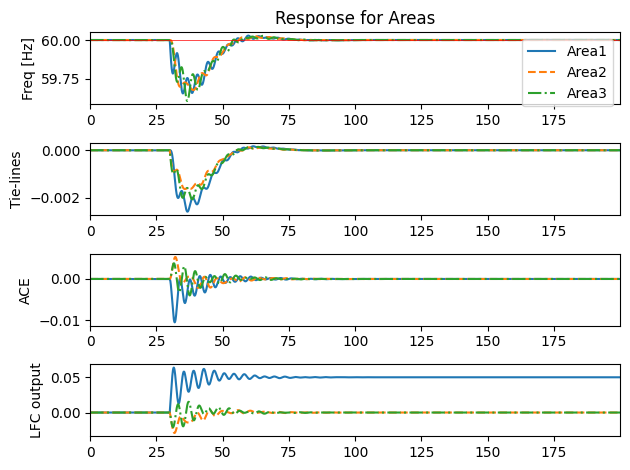

Final frequencies for each area:
Area 0: 60.0 Hz
Area 1: 60.0 Hz
Area 2: 60.0 Hz


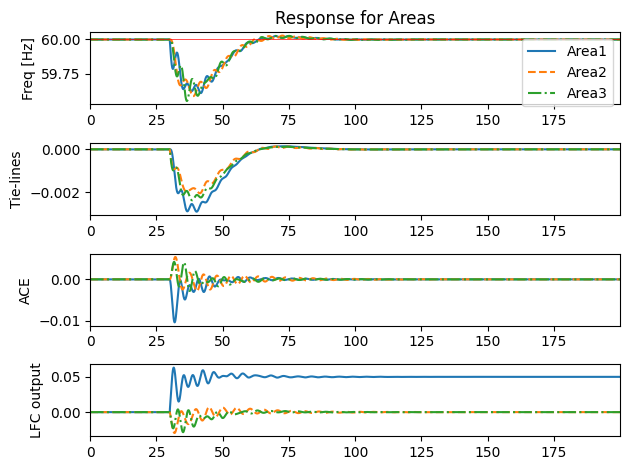

Final frequencies for each area:
Area 0: 60.0 Hz
Area 1: 60.0 Hz
Area 2: 60.0 Hz


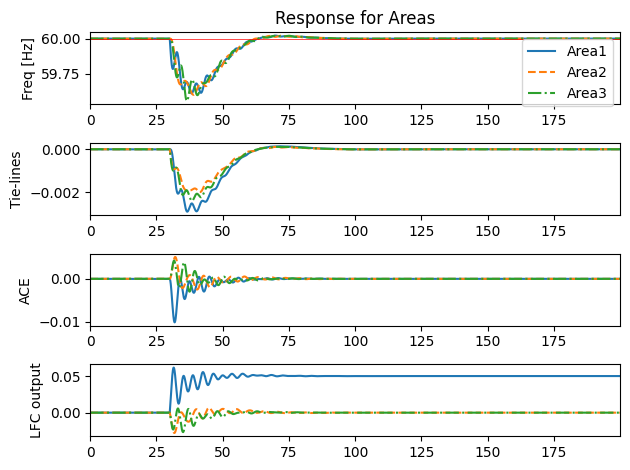

Final frequencies for each area:
Area 0: 60.0 Hz
Area 1: 60.0 Hz
Area 2: 60.0 Hz


In [76]:
number_of_splits = 3
GeneratorsParametersList = [Split1_parameters, Split2_parameters, Split3_parameters]

for split in range(number_of_splits):
    gen_params = GeneratorsParametersList[split]
    x, w, u, y = get_state_input_output_vectors(gen_params.n, gen_params.m, T)
    run_simulation_and_plot_results(gen_params.f0, gen_params.base_MV,
                   gen_params.n, gen_params.m,
                   gen_params.D, gen_params.H,
                   gen_params.Tt, gen_params.Tg,
                   gen_params.R,
                   gen_params.alpha,
                   gen_params.beta,
                   gen_params.Tij,
                   x, w, u ,y)